In [1]:
import os
import json
import time
import numpy as np
import pandas as pd
import keras
from keras import models
from keras import layers
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.utils.data_utils import Sequence
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
INDIR = 'data'
game_dir = os.path.join(INDIR, 'reviews_Video_Games_5_processed_1.json')
with open(game_dir, 'r') as f:
    games = json.load(f)

# Convert data from json to csv
games = pd.DataFrame.from_dict(games)

In [3]:
config_file = 'project_config.json'
with open(config_file, 'r') as f:
    args = json.load(f)

In [4]:
embed_path = os.path.join(args['embed_model_path'])
embed_model = FastText.load(embed_path)

In [5]:
common_args = {
    'embed_dim': args['embed_dim'],
    'embed_model': embed_model,
    'max_len': args['max_len'],
    'batch_size': args['batch_size']
}

In [7]:
def pad_sentences_with_vectors(sents, model, max_len, dim):
    """
    Zero padding sentences with length shorter than max_len,
    truncat sentences with length exceeding max_len
    Args:
        sents (list): list of tokenized sentences or strings
        model (gensim.models.FastText,model): FastText embedding model
        max_len (int): Maximum number of words in a sentence or string
        dim (int): Dimension of word vector
    Returns:
        padded (list): list of np.array with shape=(max_len, dim)
    """
#     start = time.time()
    padded = np.zeros((len(sents), max_len, dim), dtype=np.float32)
    for i in range(len(sents)):
        sent = sents[i]
        for j in range(min(len(sent), max_len)):
            padded[i][j] = model.wv[sent[j]]
#     end = time.time()
#     print('padding time: {:.2f} s'.format((end - start)))
    return padded

In [8]:
def one_hot_encode(labels, n_classes):
    """
    Reformat and reshape the input data and labels into TensorFlow format.
    Args:
        labels (array): input labels
        n_classes (int): Number of classes
    Returns:
        labels(ndarray): one-hot-encoded labels
    """
    # Map 0 to (1.0, 0.0, 0.0 ...), 1 to (0.0, 1.0, 0.0 ...)
    labels = (np.arange(n_classes) == labels[:, None]).astype(np.float32)
    return labels

In [9]:
X = list(games['reviews_clean'])
Y = games['overall'] - 1
Y = one_hot_encode(Y, args['num_class'])

<ipython-input-8-fc22b5fcb77d>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  labels = (np.arange(n_classes) == labels[:, None]).astype(np.float32)


In [10]:
class Generator(Sequence):
    def __init__(
        self,
        input_txts,
        labels=None,
        batch_size=32,
        max_len=100,
        embed_dim=300,
        embed_model=None,
        shuffle=True,
        example_per_class=None,
    ):
#         if isinstance(input_txts, list):
#             input_txts = np.array(input_txts)
        self.batch_size = batch_size
        self.embed_dim = embed_dim
        self.embed_model = embed_model
        self.example_per_class = example_per_class
        self.input_txts = input_txts
        self.labels = labels
        self.max_len = max_len
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        # limit the number of examples per class
        if self.example_per_class is not None and self.labels is not None:
            label_id, counts = np.unique(
                np.argmax(self.labels, axis=-1), return_counts=True
            )
            num_exp = np.sum(
                [min(counts[i], self.example_per_class[label_id[i]])
                 for i in range(len(label_id))]
            )
        else:
            num_exp = len(self.input_txts)
        return int(np.ceil(num_exp / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indexes of the batch
        indexes = self.indexes[
            index * self.batch_size:(index + 1) * self.batch_size
        ]
        # npy slicing
#         temp_txts = self.input_txts[indexes]
        temp_txts = [self.input_txts[i] for i in indexes]
        x = pad_sentences_with_vectors(
            temp_txts, self.embed_model, self.max_len, self.embed_dim,
        )
        # Generate augmented data
        if self.labels is not None:
            y = self.labels[indexes]
            return x, y
        return x

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        labels = self.labels
        example_per_class = self.example_per_class
        self.indexes = np.arange(len(self.input_txts))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        # limit the number of example per class
        if example_per_class is not None and labels is not None:
            num_of_exp = dict((k, 0) for k in example_per_class.keys())
            index = []
            for i in range(len(labels)):
                # current index's label id
                label_id = np.argmax(labels[self.indexes[i]])
                # append True if the number of example of class 'label_id'
                # is less than the limit number specified
                if num_of_exp[label_id] < example_per_class[label_id]:
                    index.append(True)
                    num_of_exp[label_id] += 1
                else:
                    index.append(False)
            # slice out limited number of indexes
            self.indexes = self.indexes[index]

In [11]:
X = list(games['reviews_clean'])
Y = games['overall'] - 1
Y = one_hot_encode(Y, args['num_class'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=123)

<ipython-input-8-fc22b5fcb77d>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  labels = (np.arange(n_classes) == labels[:, None]).astype(np.float32)


In [164]:
input_embed = layers.Input(shape=(args['max_len'], args['embed_dim']), name='input_embedding')
lstm_out = layers.LSTM(150, return_sequences=True)(input_embed)
lstm_out = layers.LSTM(150, return_sequences=False, name='sentence_embedding')(lstm_out)
fc = layers.Dense(32, activation='linear')(lstm_out)
fc = layers.Dense(args['num_class'], activation='linear')(fc)
out = layers.Activation('softmax')(fc)
loss_func = 'categorical_crossentropy'
metrics = 'accuracy'
model = models.Model(input_embed, out)
model.compile(optimizer='adam', metrics=[metrics], loss=loss_func)
        
train_generator = Generator(X_train,
                            Y_train,
                            **common_args)
validation_generator = Generator(X_test,
                                 Y_test,
                                 shuffle=False,
                                 **common_args)
# start training
model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=args['epochs'],
                    verbose=1)

model.save(args['model_path'])


/home/chrys/mypy/msc/gitlab/recommender-system/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
2894/2894 [==============================] - 63s 21ms/step - loss: 1.2852 - accuracy: 0.5186 - val_loss: 1.2782 - val_accuracy: 0.5188
Epoch 2/3
2894/2894 [==============================] - 60s 21ms/step - loss: 1.2769 - accuracy: 0.5180 - val_loss: 1.2737 - val_accuracy: 0.5188
Epoch 3/3
2894/2894 [==============================] - 63s 22ms/step - loss: 1.2712 - accuracy: 0.5199 - val_loss: 1.2655 - val_accuracy: 0.5188


In [22]:
model = models.load_model(args['model_path'])

In [12]:
def feature_user(users):
    processed_feature = []
    for f in users['features']:
        f_ = np.zeros(150)
        for x in f:
            f_ += div_norm(x)
        f_ = f_ / len(f)
        processed_feature.append(f_)
    users['features'] = processed_feature
    return users

In [13]:
def feature_item(items):
    processed_feature = []
    for f in items['features']:
        f_ = np.zeros(150)
        for x in f:
            f_ += div_norm(x)
        f_ = f_ / len(f)
        processed_feature.append(f_)
    items['features'] = processed_feature
    return items

In [14]:
def feature_map_user(users):
    user_features_map = {}
    for i in users['reviewerID'].unique():
        user_features_map[i] = {}
        for j in users[users['reviewerID'] == i].index:
            user_features_map[i][users['overall'][j]] = users['features'][j]
    return user_features_map

In [15]:
def feature_map_item(items):
    item_features_map = {}
    for i in items['asin'].unique():
        item_features_map[i] = {}
        for j in items[items['asin'] == i].index:
            item_features_map[i][items['overall'][j]] = items['features'][j]
    return item_features_map

In [16]:
def l2_norm(x):
    return np.sqrt(np.sum(x**2))

def div_norm(x):
    norm_value = l2_norm(x)
    if norm_value > 0:
        return x * ( 1.0 / norm_value)
    else:
        return x

In [17]:
from scipy import spatial
def cosine_similarity(feature1, feature2):
    cossim = 1 - spatial.distance.cosine(feature1, feature2)
    return cossim

In [18]:
def compare(user, item):
    ratings = [1, 2, 3, 4, 5]
    similarity = []
    for i in ratings:
        try:
            user_ = user[i]
        except KeyError:
            user_ = np.zeros(150) + 0.0001

        for j in ratings:
            try:
                item_ = item[j]
            except KeyError:
                item_ = np.zeros(150) + 0.0001
        comparison_u = user_ == np.zeros(150) + 0.0001
        comparison_i = item_ == np.zeros(150) + 0.0001
        if comparison_u.all() and comparison_i.all():
            similarity.append(0)
        else:
            similarity.append(cosine_similarity(user_, item_))
#         print(similarity)
    return similarity.index(max(similarity))

In [19]:
def predict_rating(df_test, user_features_map, item_features_map):
    predictions = []
    for x in range(len(df_test)):
        u = user_features_map[df_test['reviewerID'][x]]
        i = item_features_map[df_test['asin'][x]]
        prediction = compare(u, i)
        predictions.append(prediction)
    return predictions

In [20]:
def predict_feature(games, model):
    acc = []
    precision = []
    recall = []
    f1_score = []
    start_time = time.time()
    for i in range(10):
        df_train, df_test = train_test_split(games, test_size = 0.20)
        df_test = df_test.reset_index()
        X_test = list(df_test['reviews_clean'])
        Y_test = df_test['overall'] - 1
        Y_test = one_hot_encode(Y_test, args['num_class'])

        validation_generator = Generator(X_test,
                                         Y_test,
                                         shuffle=False,
                                         **common_args)

        feature_extractor = models.Model(model.inputs, model.layers[2].output)
        features = feature_extractor.predict(validation_generator)
        features_ = [x for x in features]
        df_test['features'] = features_
        
        users = df_test.groupby(['reviewerID', 'overall'])['features'].apply(list).reset_index()
        items = df_test.groupby(['asin', 'overall'])['features'].apply(list).reset_index()
        users = feature_user(users)
        items = feature_item(items)
        user_features_map = feature_map_user(users)
        item_features_map = feature_map_item(items)
        
        predictions = predict_rating(df_test, user_features_map, item_features_map)
        predict_value = [(x + 1) for x in predictions]
        true_value = [int(x) for x in df_test['overall']]
        
        acc.append(classification_report(true_value, predict_value, output_dict=True)['accuracy'])
        precision.append(classification_report(true_value, predict_value, output_dict=True)['macro avg']['precision'])
        recall.append(classification_report(true_value, predict_value, output_dict=True)['macro avg']['recall'])
        f1_score.append(classification_report(true_value, predict_value, output_dict=True)['macro avg']['f1-score'])
    
    print('Time elapsed: {:4f}\n'.format(time.time() - start_time))

    return acc, precision, recall, f1_score

In [ ]:
acc, precision, recall, f1_score = predict_feature(games, model)

In [99]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embedding (InputLayer) [(None, 50, 300)]         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 150)           270600    
_________________________________________________________________
sentence_embedding (LSTM)    (None, 150)               180600    
_________________________________________________________________
dense_16 (Dense)             (None, 32)                4832      
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 165       
_________________________________________________________________
activation_8 (Activation)    (None, 5)                 0         
Total params: 456,197
Trainable params: 456,197
Non-trainable params: 0
____________________________________________________

### Confusion matrix

In [ ]:
df_train, df_test = train_test_split(games, test_size = 0.20, random_state=123)
df_test = df_test.reset_index()
X_test = list(df_test['reviews_clean'])
Y_test = df_test['overall'] - 1
Y_test = one_hot_encode(Y_test, args['num_class'])

validation_generator = Generator(X_test,
                                 Y_test,
                                 shuffle=False,
                                 **common_args)

feature_extractor = models.Model(model.inputs, model.layers[2].output)
features = feature_extractor.predict(validation_generator)
features_ = [x for x in features]
df_test['features'] = features_

users = df_test.groupby(['reviewerID', 'overall'])['features'].apply(list).reset_index()
items = df_test.groupby(['asin', 'overall'])['features'].apply(list).reset_index()
users = feature_user(users)
items = feature_item(items)
user_features_map = feature_map_user(users)
item_features_map = feature_map_item(items)

predictions = predict_rating(df_test, user_features_map, item_features_map)
predict_value = [(x + 1) for x in predictions]
true_value = [int(x) for x in df_test['overall']]

In [ ]:
confusion_matrix(true_value, predict_value)

In [23]:
X_test = list(games['reviews_clean'])
Y_test = games['overall'] - 1
Y_test = one_hot_encode(Y_test, args['num_class'])


validation_generator = Generator(X_test,
                                 Y_test,
                                 shuffle=False,
                                 **common_args)

feature_extractor = models.Model(model.inputs, model.layers[2].output)
features = feature_extractor.predict(validation_generator)
game_features = [x for x in features]

<ipython-input-8-fc22b5fcb77d>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  labels = (np.arange(n_classes) == labels[:, None]).astype(np.float32)


In [24]:
columns = [str(x + 1) for x in range(150)]
# game_df = pd.DataFrame({'features': game_features})
game_df = pd.DataFrame(list(map(np.ravel, game_features)), columns=columns)

game_df['overall'] = [int(x) for x in games['overall']]

### LDA for FastText+LSTM

In [26]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def preprocessdata(data):
    """
        Preprocess the data with StandardScalar and Label Encoder
    :param data: input dataframe of training or test set 
    """
    labels = data['overall']
    features = data.drop(['overall'], axis=1)
    columns = features.columns
    enc = LabelEncoder()
    enc.fit(labels)
    labels = enc.transform(labels)
    features = StandardScaler().fit_transform(features)
    return features, labels, columns, data['overall']

In [28]:
Xtrain, Ytrain, COLUMNS, ACTUAL_LABELS = preprocessdata(game_df)

In [29]:
def applylda(trainX, trainY, actual_labels):
    lda = LinearDiscriminantAnalysis()
    lda.fit(trainX, trainY)
    # Plotting the Cumulative Summation of the Explained Variance
    plt.figure()
    plt.plot(np.cumsum(lda.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')  # for each component
    plt.title('Segmentation Dataset Explained Variance')
    plt.show(block=True)
    lda = LinearDiscriminantAnalysis(n_components=4)
    lda.fit(trainX, trainY)
    trainX_lda = lda.transform(trainX)
    return trainX_lda
#     # Plot Pairwise relationship between LDA components
#     plt.figure(figsize=(10, 8), dpi=80)
#     visualizedf = pd.DataFrame(trainX_lda, columns=['LDA1', 'LDA2', 'LDA3', 'LDA4'])
#     visualizedf = pd.concat([visualizedf, pd.DataFrame({'LABELS': actual_labels})], axis=1)
# #     print(visualizedf[0:5])
# #     print(visualizedf.sample(n=5))
#     sns.pairplot(visualizedf, vars=visualizedf.columns[:-1], hue="LABELS", palette="tab10_r")
#     plt.show(block=True)
# #     applyrandomforest(trainX_lda, testX_lda, trainY, testY)

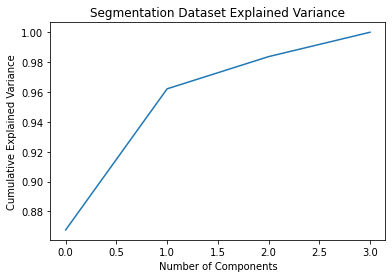

In [30]:
trainX_lda = applylda(Xtrain, Ytrain, actual_labels=ACTUAL_LABELS)

In [31]:
from scipy.spatial import ConvexHull
def encircle(x, y, ax=None, **kw):  #定义encircle函数，圈出重点关注的点
    if not ax: ax = plt.gca()
    p = np.c_[x, y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices, :], **kw)
    ax.add_patch(poly)

In [32]:
palette = {1: 'darkgoldenrod', 2: 'lightgreen', 3: 'lightcoral', 4: 'royalblue', 5: 'mediumpurple'}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 864x864 with 0 Axes>

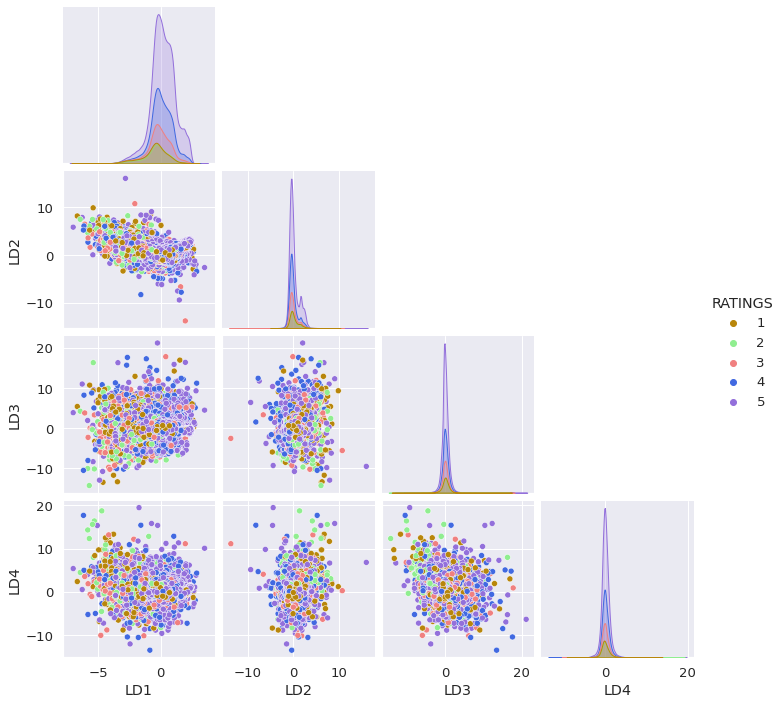

In [45]:
# Plot Pairwise relationship between LDA components
plt.figure(figsize=(12, 12))
visualizedf = pd.DataFrame(trainX_lda, columns=['LD1', 'LD2', 'LD3', 'LD4'])
visualizedf = pd.concat([visualizedf, pd.DataFrame({'RATINGS': ACTUAL_LABELS})], axis=1)
#     print(visualizedf[0:5])
#     print(visualizedf.sample(n=5))
sns.set(font_scale=1.2)
lda_plot = sns.pairplot(visualizedf, vars=visualizedf.columns[:-1], hue="RATINGS", palette=palette, diag_kind="kde", corner=True)
# lda_plot.set_xlabel(fontsize=20)
# lda_plot.set_ylabel(fontsize=20)
# lda_plot.map_lower(sns.kdeplot, levels=4, color=".2")
# plt.show(block=True)
#     applyrandomforest(trainX_lda, testX_lda, trainY, testY)
# g.map_lower(sns.kdeplot, levels=4, color=".2")
# lda_plot.fig.suptitle('Pairwise Scatterplot of LDA - FastText+LSTM', fontsize=18, y=1.05)
# (lda_plot.set_title('Title')
plt.savefig('PNG/lda_plot_lstm.eps', bbox_inches='tight')

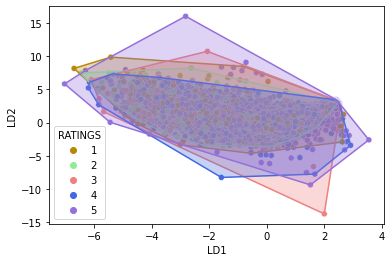

In [37]:
ax = sns.scatterplot(data=visualizedf, x="LD1", y="LD2", hue="RATINGS", palette=palette)
label1 = visualizedf.loc[visualizedf.RATINGS == 1, :]
encircle(label1.LD1,
         label1.LD2,
         ec="pink",
         fc=palette[1],
         alpha=0.3)
encircle(label1.LD1,
         label1.LD2,
         ec=palette[1],
         fc="none",
         linewidth=1.5)

label2 = visualizedf.loc[visualizedf.RATINGS == 2, :]
encircle(label2.LD1,
         label2.LD2,
         ec="pink",
         fc=palette[2],
         alpha=0.3)
encircle(label2.LD1,
         label2.LD2,
         ec=palette[2],
         fc="none",
         linewidth=1.5)

label3 = visualizedf.loc[visualizedf.RATINGS == 3, :]
encircle(label3.LD1,
         label3.LD2,
         ec="pink",
         fc=palette[3],
         alpha=0.3)
encircle(label3.LD1,
         label3.LD2,
         ec=palette[3],
         fc="none",
         linewidth=1.5)

label4 = visualizedf.loc[visualizedf.RATINGS == 4, :]
encircle(label4.LD1,
         label4.LD2,
         ec="pink",
         fc=palette[4],
         alpha=0.3)
encircle(label4.LD1,
         label4.LD2,
         ec=palette[4],
         fc="none",
         linewidth=1.5)

label5 = visualizedf.loc[visualizedf.RATINGS == 5, :]
encircle(label5.LD1,
         label5.LD2,
         ec="pink",
         fc=palette[5],
         alpha=0.3)
encircle(label5.LD1,
         label5.LD2,
         ec=palette[5],
         fc="none",
         linewidth=1.5)

# ax.set_title('Scatterplot of LDA1 and LDA2 - FastText+LSTM', fontsize=15)
plt.savefig('PNG/lda_scatterplot_lstm.png', dpi=300)